In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

## Data

In [2]:
ticker = 'NVDA'
# ticker = 'IBM'
# ticker = 'INTC'
data = yf.download(ticker, start='2021-01-01', end='2024-10-13')

df = data[['Open', 'Close', 'Low', 'High', 'Volume']]
df

[*********************100%%**********************]  1 of 1 completed


,Open,Close,Low,High,Volume
Date,,,,,
2021-01-04,13.104250,13.113500,12.962500,13.652500,560640000
2021-01-05,13.099750,13.404750,13.087000,13.443500,322760000
2021-01-06,13.222500,12.614500,12.586000,13.245000,580424000
2021-01-07,12.967500,13.344000,12.886500,13.377750,461480000
2021-01-08,13.362500,13.276750,13.042000,13.421000,292528000
...,...,...,...,...,...
2024-10-07,124.989998,127.720001,124.949997,130.639999,346250200
2024-10-08,130.259995,132.889999,129.419998,133.479996,285722500
2024-10-09,134.110001,132.649994,131.380005,134.520004,246191600


In [3]:
closeData = df.Close.values.astype('float32')

total_rows = closeData.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

XTrain = closeData[:train_end]
XValidation = closeData[train_end:validation_end]
XTest = closeData[validation_end:]

print("Training set size:", len(XTrain), f"({len(XTrain)/len(closeData)*100}%)")
print("Validation set size:", len(XValidation), f"({len(XValidation)/len(closeData)*100}%)")
print("Test set size:", len(XTest), f"({len(XTest)/len(closeData)*100}%)")

Training set size: 665 (70.0%)
Validation set size: 190 (20.0%)
Test set size: 95 (10.0%)


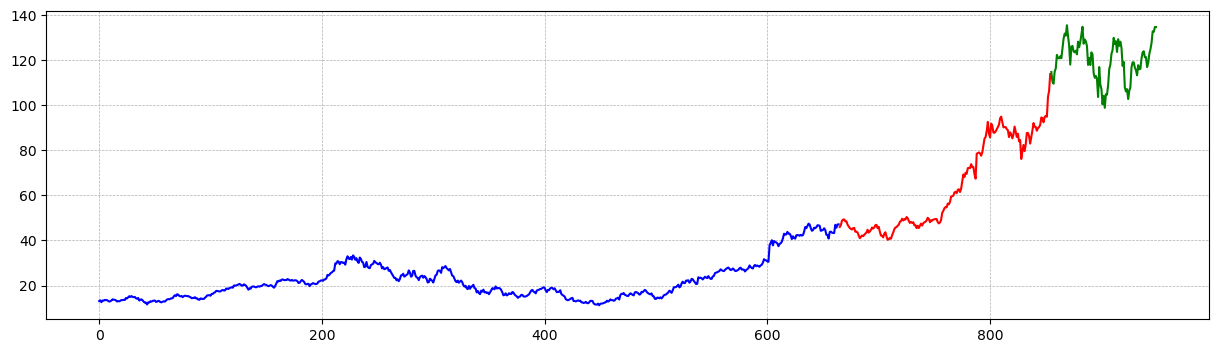

In [4]:
plt.figure(figsize=(15,4))

# plt.plot(openData, color='gray')
plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show() 

## Processing data

In [5]:
closeData.shape

(950,)

In [6]:
closeData = closeData.reshape(-1,1)
XTrain = XTrain.reshape(-1,1)
XValidation = XValidation.reshape(-1,1)
XTest = XTest.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(closeData)

openData = scaler.transform(closeData)
XTrain = scaler.transform(XTrain)
XValidation = scaler.transform(XValidation)
XTest = scaler.transform(XTest)

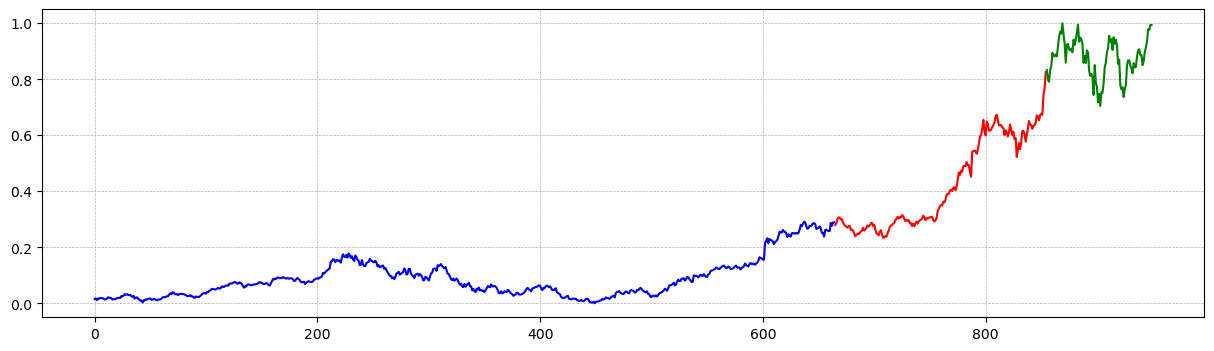

In [7]:
plt.figure(figsize=(15,4))

plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [8]:
def create_lookback(dataset, lookback, device):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        after_window = dataset[i + lookback]
        X.append(window)
        y.append(after_window)
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    return X_tensor, y_tensor

In [9]:
# Dispositivo para entrenamiento (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
lookback = 2
XTrain_tensor, TTrain_tensor = create_lookback(XTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback(XValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback(XTest, lookback, device)

Timeseries_tensor, TTimeseries_tensor = create_lookback(openData, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([663, 2, 1]), 
TTrain_tensor shape: torch.Size([663, 1])

XValidation_tensor shape: torch.Size([188, 2, 1]), 
TValidation_tensor shape: torch.Size([188, 1])

XTest_tensor shape: torch.Size([93, 2, 1]), 
TTest_tensor shape: torch.Size([93, 1])


In [11]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

21
6
3


## LSTM Model

In [12]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=16, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

#### Training and Validation

Epoch [5/50] - Training Loss: 0.0050, Validation Loss: 0.1394, Learning Rate: 0.000500
Validation RMSE: 45.856773


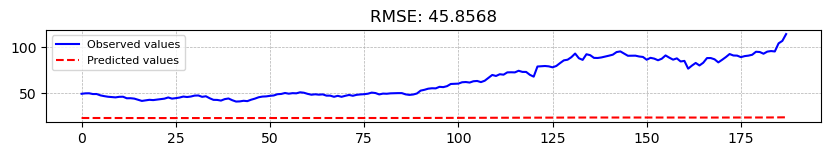


Epoch [10/50] - Training Loss: 0.0046, Validation Loss: 0.1288, Learning Rate: 0.000500
Validation RMSE: 44.09224


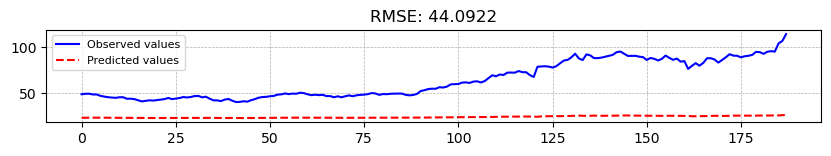


Epoch [15/50] - Training Loss: 0.0038, Validation Loss: 0.1004, Learning Rate: 0.000500
Validation RMSE: 38.90898


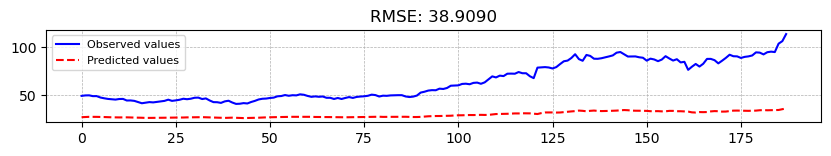


Epoch [20/50] - Training Loss: 0.0022, Validation Loss: 0.0468, Learning Rate: 0.000500
Validation RMSE: 26.571224


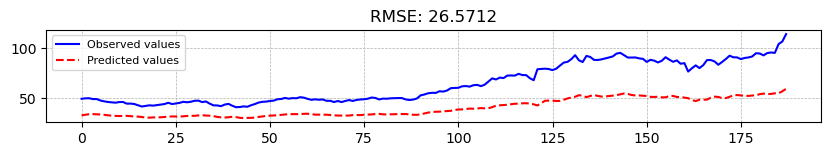


Epoch [25/50] - Training Loss: 0.0006, Validation Loss: 0.0034, Learning Rate: 0.000500
Validation RMSE: 7.104026


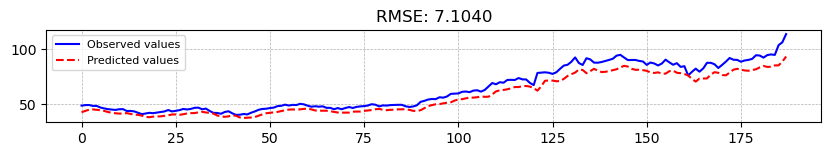


Epoch [30/50] - Training Loss: 0.0004, Validation Loss: 0.0010, Learning Rate: 0.000500
Validation RMSE: 3.9028494


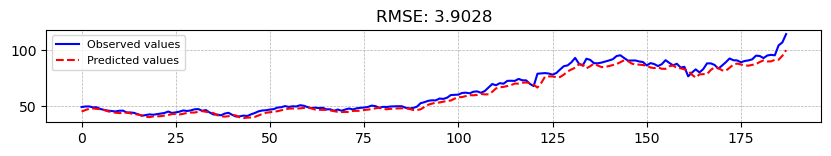


Epoch [35/50] - Training Loss: 0.0003, Validation Loss: 0.0009, Learning Rate: 0.000500
Validation RMSE: 3.7584925


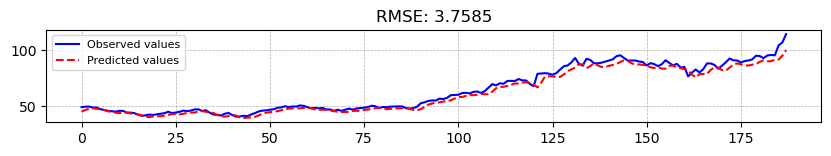


Epoch [40/50] - Training Loss: 0.0003, Validation Loss: 0.0007, Learning Rate: 0.000500
Validation RMSE: 3.2483056


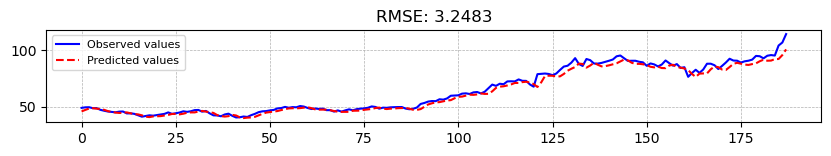


Epoch [45/50] - Training Loss: 0.0003, Validation Loss: 0.0009, Learning Rate: 0.000500
Validation RMSE: 3.6128778


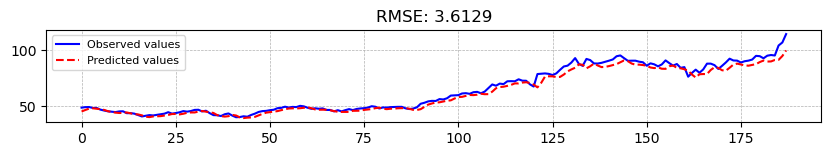


Early stopping! in epoch 49
Training Loss: 0.0004, Validation Loss: 0.0007, Learning Rate: 0.000500
Validation RMSE: 3.232993     std: 0.0


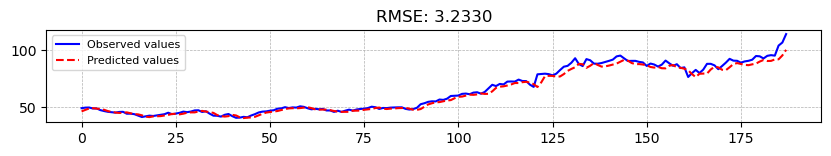

In [13]:
learning_rate = 5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn =  nn.MSELoss()
# loss_fn = nn.L1Loss()
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
 
n_epochs = 50
early_stop_count = 0
min_val_loss = float('inf')
train_hist = []
val_hist = [] 
test_loss = None  

for epoch in range(n_epochs):

    total_loss = 0.0
    
    ''' Training Phase'''
    model.train() 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() 
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    ''' Validation Phase'''
    model.eval()
    total_val_loss = 0.0 
    y_predicted = []
    y_observed = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            y_predicted.append(y_pred.cpu().numpy())
            y_observed.append(y_batch.cpu().numpy())

            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)
    # scheduler.step(average_val_loss)

    predicted = np.concatenate(y_predicted, axis=0)
    observed = np.concatenate(y_observed, axis=0)
    
    predicted = scaler.inverse_transform(predicted)
    observed = scaler.inverse_transform(observed)
    
    rmses = []
    for i in range(predicted.shape[1]):
        rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
        rmses.append(rmse)
    rmse_mean = np.mean(rmses)

    if average_val_loss < min_val_loss:
        min_val_loss = average_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Early stopping! in epoch {epoch+1}')
        print(f'Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean, "    std:", np.std(rmses))
        plt.figure(figsize=(10, 1.2))
        plt.plot(np.mean(observed, axis=1), label='Observed values', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='--', color="red")
        plt.title(f'RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()

        break
    
    if (epoch+1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean)
        plt.figure(figsize=(10, 1.2))
        plt.plot(np.mean(observed, axis=1), label='Observed values', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='--', color="red")
        plt.title(f'RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()

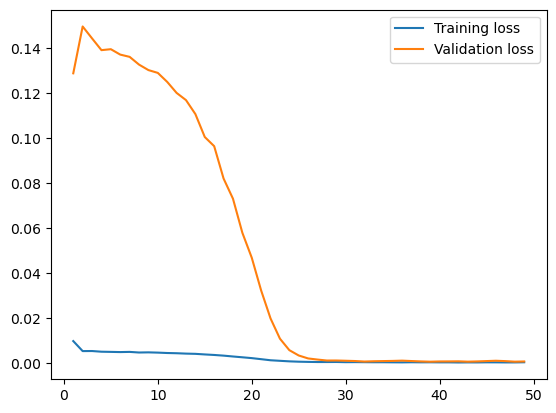

In [14]:
x = np.linspace(1,len(val_hist),len(val_hist))
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.legend()

plt.show()

#### Evaluation on test data

RMSE promedio: 9.947008     std: 0.0


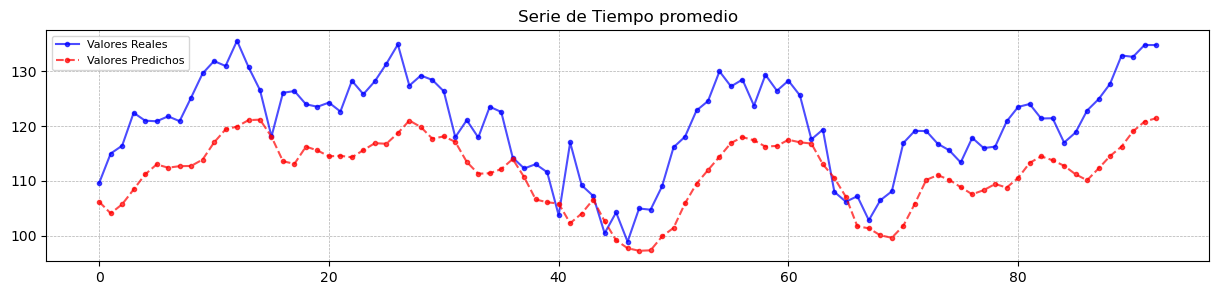

In [15]:
y_predicted = []
y_observed = []

# Final Evaluation on Test Set
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)

        # y_predicted.extend(y_pred.cpu().numpy())
        y_predicted.append(y_pred.cpu().numpy())
        y_observed.append(y_batch.cpu().numpy())

predicted = np.concatenate(y_predicted, axis=0)
observed = np.concatenate(y_observed, axis=0)

predicted = scaler.inverse_transform(predicted)
observed = scaler.inverse_transform(observed)

# Calculamos el RMSE por cada serie de tiempo
rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)

best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)


print("RMSE promedio:", np.mean(rmses), "    std:", np.std(rmses))

plt.figure(figsize=(15, 3))
plt.plot(observed, label='Valores Reales', marker='.', color='blue', alpha=0.7)
plt.plot(predicted, label='Valores Predichos', linestyle='--', marker='.', color="red", alpha=0.7)
plt.title(f'Serie de Tiempo promedio')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

#### All data

RMSE promedio:  3.5617678


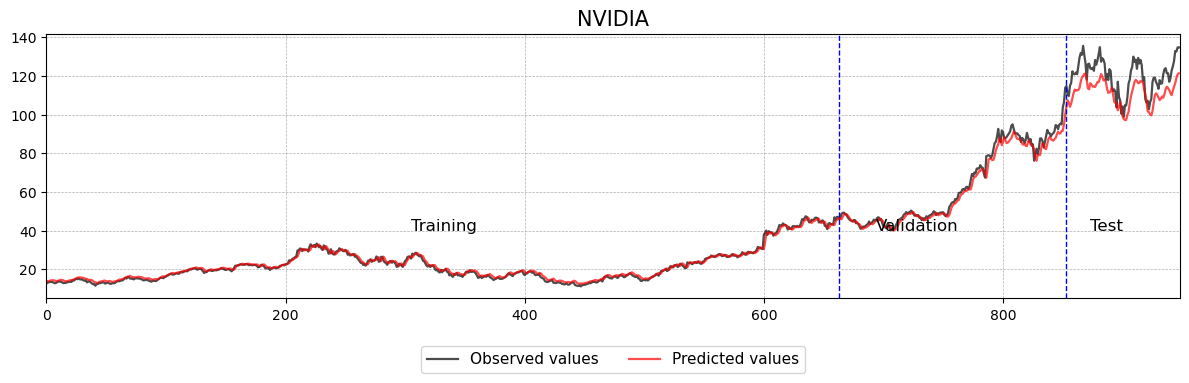

In [16]:
model.eval()
with torch.no_grad():
    y_pred_test = model(Timeseries_tensor)

predicted = scaler.inverse_transform(y_pred_test.cpu().numpy())
observed = scaler.inverse_transform(TTimeseries_tensor.cpu().numpy())

rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)
    
best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print("RMSE promedio: ", np.mean(rmses))

plt.figure(figsize=(12, 4))
plt.plot(observed, color='k', linewidth=1.6, alpha=.7, label='Observed values')
plt.plot(predicted, label='Predicted values', linestyle='-', color="red", linewidth=1.6, alpha=0.7)

plt.axvline(x=len(XTrain)-lookback, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='blue', linestyle='--', linewidth=1)

plt.text(len(XTrain) / 2, np.mean(observed) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.3, 'Test', fontsize=12, color='black', ha='center')

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title('NVIDIA', fontsize=15)
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# Predicting the price with multivariate LSTM model

In [17]:
df

,Open,Close,Low,High,Volume
Date,,,,,
2021-01-04,13.104250,13.113500,12.962500,13.652500,560640000
2021-01-05,13.099750,13.404750,13.087000,13.443500,322760000
2021-01-06,13.222500,12.614500,12.586000,13.245000,580424000
2021-01-07,12.967500,13.344000,12.886500,13.377750,461480000
2021-01-08,13.362500,13.276750,13.042000,13.421000,292528000
...,...,...,...,...,...
2024-10-07,124.989998,127.720001,124.949997,130.639999,346250200
2024-10-08,130.259995,132.889999,129.419998,133.479996,285722500
2024-10-09,134.110001,132.649994,131.380005,134.520004,246191600


Now, our prediction consist of all the orhers columns except our target (Close in our case).

In [18]:
X, y = df.drop(columns=['Close', 'Volume']), df.Close.values
# X, y = df, df.Close.values
X.shape, y.shape

((950, 3), (950,))

In [19]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [20]:
total_rows = X_trans.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

# variables
XTrain = X_trans[:train_end]
XValidation = X_trans[train_end:validation_end]
XTest = X_trans[validation_end:]

# target
TTrain = y_trans[:train_end]
TValidation = y_trans[train_end:validation_end]
TTest = y_trans[validation_end:]

In [21]:
def create_lookback_many_to_one(input_sequences, output_sequence, lookback, device):
    """
    Prepares the dataset for a many-to-one LSTM model, where each input sequence has 
    a corresponding single target value from a separate output sequence.
    
    Parameters:
        input_sequences (array-like): The input time series data.
        output_sequence (array-like): The target time series data.
        lookback (int): Number of previous time steps to consider for each prediction.
        device (str): The device on which tensors should be stored ('cpu' or 'cuda').
        
    Returns:
        X_tensor (torch.Tensor): Tensor of input sequences with shape (num_samples, lookback, num_features).
        y_tensor (torch.Tensor): Tensor of target values with shape (num_samples,).
    """
    X, y = [], []
    for i in range(len(input_sequences) - lookback):
        # Extract a window of length `lookback` from `input_sequences`
        window = input_sequences[i:(i + lookback)]
        # Target is the single value from `output_sequence` after the window
        target_value = output_sequence[i + lookback]
        
        X.append(window)
        y.append(target_value)
    
    # Convert lists to tensors and move to specified device
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    
    return X_tensor, y_tensor


In [22]:
lookback = 50
XTrain_tensor, TTrain_tensor = create_lookback_many_to_one(XTrain, TTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback_many_to_one(XValidation, TValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback_many_to_one(XTest, TTest, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([615, 50, 3]), 
TTrain_tensor shape: torch.Size([615, 1])

XValidation_tensor shape: torch.Size([140, 50, 3]), 
TValidation_tensor shape: torch.Size([140, 1])

XTest_tensor shape: torch.Size([45, 50, 3]), 
TTest_tensor shape: torch.Size([45, 1])


In [23]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

39
5
2


In [24]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=32, batch_first=True)
        self.fc1 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

Epoch [5/100] - Training Loss: 0.0006, Validation Loss: 0.0107, Learning Rate: 0.001000
Validation RMSE: 11.050512


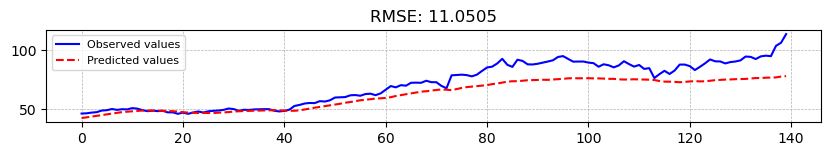


Epoch [10/100] - Training Loss: 0.0004, Validation Loss: 0.0111, Learning Rate: 0.001000
Validation RMSE: 11.431297


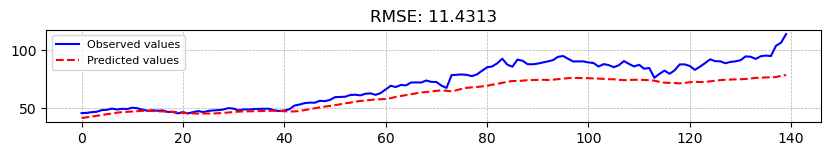


Epoch [15/100] - Training Loss: 0.0003, Validation Loss: 0.0062, Learning Rate: 0.001000
Validation RMSE: 8.38449


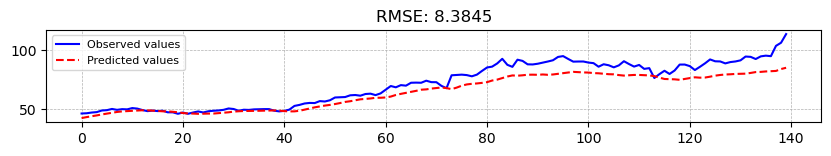


Epoch [20/100] - Training Loss: 0.0002, Validation Loss: 0.0014, Learning Rate: 0.001000
Validation RMSE: 3.7463865


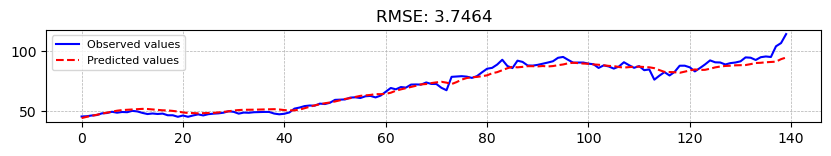


Epoch [25/100] - Training Loss: 0.0002, Validation Loss: 0.0036, Learning Rate: 0.001000
Validation RMSE: 6.4149113


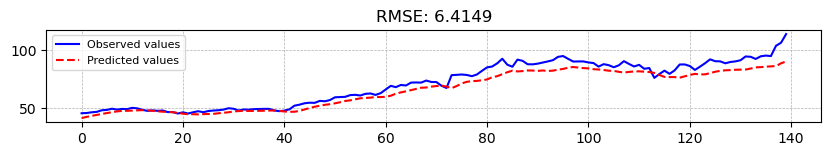


Epoch [30/100] - Training Loss: 0.0002, Validation Loss: 0.0023, Learning Rate: 0.001000
Validation RMSE: 4.993634


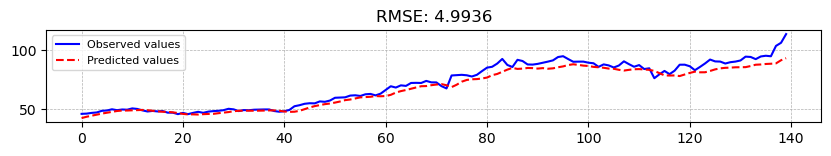


Epoch [35/100] - Training Loss: 0.0001, Validation Loss: 0.0024, Learning Rate: 0.001000
Validation RMSE: 5.1066647


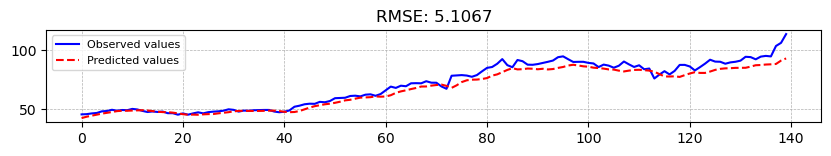


Epoch [40/100] - Training Loss: 0.0001, Validation Loss: 0.0025, Learning Rate: 0.001000
Validation RMSE: 5.313704


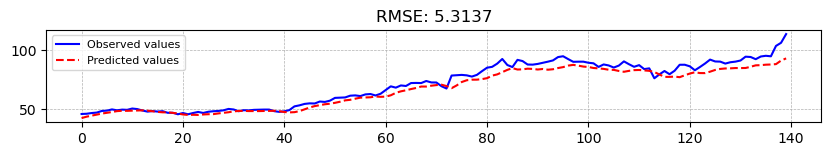


Epoch [45/100] - Training Loss: 0.0001, Validation Loss: 0.0017, Learning Rate: 0.001000
Validation RMSE: 4.328323


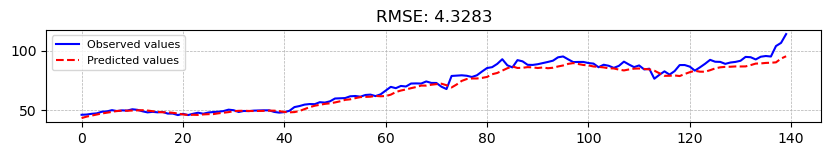


Early stopping! in epoch 47
Training Loss: 0.0002, Validation Loss: 0.0011, Learning Rate: 0.001000
Validation RMSE: 3.4486513     std: 0.0


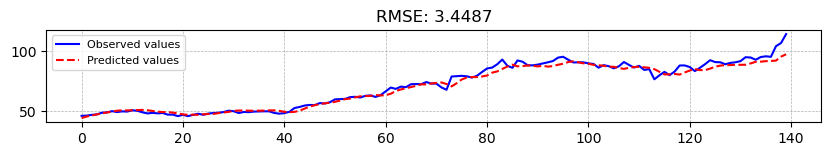

In [25]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn =  nn.MSELoss()
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
 
n_epochs = 100
early_stop_count = 0
min_val_loss = float('inf')
train_hist = []
val_hist = [] 
test_loss = None  

for epoch in range(n_epochs):
    total_loss = 0.0  
    ''' Training Phase'''
    model.train() 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() 
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    ''' Validation Phase'''
    model.eval()
    total_val_loss = 0.0 
    y_predicted = []
    y_observed = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            y_predicted.append(y_pred.cpu().numpy())
            y_observed.append(y_batch.cpu().numpy())

            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)
    # scheduler.step(average_val_loss)

    predicted = np.concatenate(y_predicted, axis=0)
    observed = np.concatenate(y_observed, axis=0)
    
    predicted = mm.inverse_transform(predicted)
    observed = mm.inverse_transform(observed)
    
    rmses = []
    for i in range(predicted.shape[1]):
        rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
        rmses.append(rmse)
    rmse_mean = np.mean(rmses)

    if average_val_loss < min_val_loss:
        min_val_loss = average_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Early stopping! in epoch {epoch+1}')
        print(f'Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean, "    std:", np.std(rmses))
        plt.figure(figsize=(10, 1.2))
        plt.plot(np.mean(observed, axis=1), label='Observed values', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='--', color="red")
        plt.title(f'RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()

        break
    
    if (epoch+1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean)
        plt.figure(figsize=(10, 1.2))
        plt.plot(np.mean(observed, axis=1), label='Observed values', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='--', color="red")
        plt.title(f'RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()

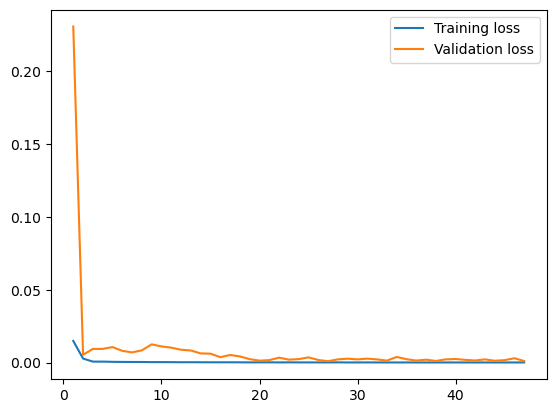

In [26]:
x = np.linspace(1,len(val_hist),len(val_hist))
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.legend()

plt.show()

In [27]:
Timeseries_tensor, TTimeseries_tensor = create_lookback_many_to_one(X_trans, y_trans, lookback, device)
Timeseries_tensor.shape, TTimeseries_tensor.shape

(torch.Size([900, 50, 3]), torch.Size([900, 1]))

RMSE promedio:  4.4846177


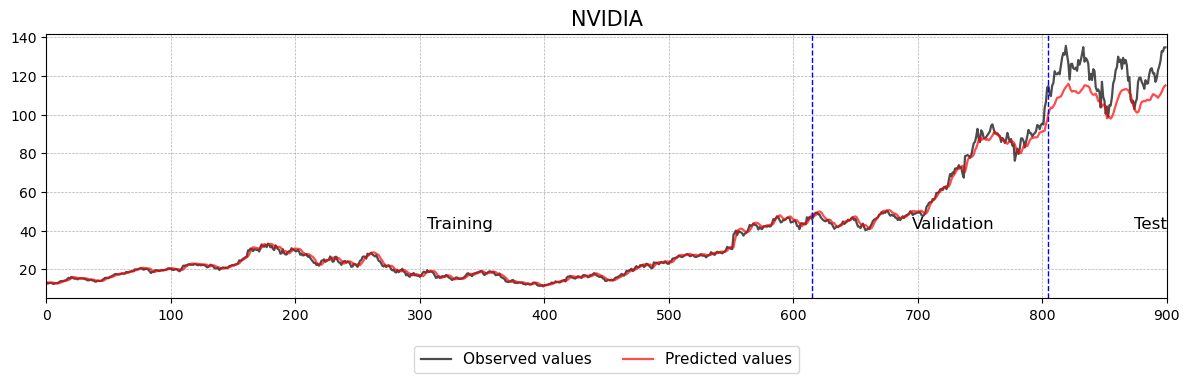

In [28]:
model.eval()
with torch.no_grad():
    y_pred_test = model(Timeseries_tensor)

predicted = mm.inverse_transform(y_pred_test.cpu().numpy())
observed = mm.inverse_transform(TTimeseries_tensor.cpu().numpy())

rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)
    
best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print("RMSE promedio: ", np.mean(rmses))

plt.figure(figsize=(12, 4))
plt.plot(observed, color='k', linewidth=1.6, alpha=.7, label='Observed values')
plt.plot(predicted, label='Predicted values', linestyle='-', color="red", linewidth=1.6, alpha=0.7)

plt.axvline(x=len(XTrain)-lookback, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='blue', linestyle='--', linewidth=1)

plt.text(len(XTrain) / 2, np.mean(observed) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.3, 'Test', fontsize=12, color='black', ha='center')

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title('NVIDIA', fontsize=15)
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## **Multistep**

In [29]:
def split_sequences(input_sequences, output_sequences, n_steps_in, n_steps_out, device):
    X, y = [], []
    for i in range(len(input_sequences)):
        # Define the end of this input sequence
        end_ix = i + n_steps_in
        # Define the end of the output sequence
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(input_sequences):
            break
        # Input and output sequences
        seq_x = input_sequences[i:end_ix]
        seq_y = output_sequences[end_ix:out_end_ix]  # Note: No '-1' here
        X.append(seq_x)
        y.append(seq_y)
    # Convert lists to tensors and move to specified device
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    
    return X_tensor, y_tensor


In [30]:
XTrain_tensor, TTrain_tensor  = split_sequences(XTrain, TTrain, 50, 10, device)
XValidation_tensor, TValidation_tensor = split_sequences(XValidation, TValidation, 50, 10, device)
XTest_tensor, TTest_tensor = split_sequences(XTest, TTest, 50, 10, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([606, 50, 3]), 
TTrain_tensor shape: torch.Size([606, 10, 1])

XValidation_tensor shape: torch.Size([131, 50, 3]), 
TValidation_tensor shape: torch.Size([131, 10, 1])

XTest_tensor shape: torch.Size([36, 50, 3]), 
TTest_tensor shape: torch.Size([36, 10, 1])


In [31]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

38
5
2


In [32]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, n_steps_out):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.n_steps_out = n_steps_out
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size * n_steps_out)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        # Use the last time step's output
        out = output[:, -1, :]  # Shape: (batch_size, hidden_size)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc(out)  # Shape: (batch_size, output_size * n_steps_out)
        # Reshape to (batch_size, n_steps_out, output_size)
        out = out.view(-1, self.n_steps_out, output_size)
        return out


In [33]:
input_size = XTrain_tensor.shape[2]   # Number of input features
hidden_size = 32
num_layers = 1
output_size = TTrain_tensor.shape[2]  # Number of output features
n_steps_out = TTrain_tensor.shape[1]  # Number of future time steps

model = LSTM(input_size, hidden_size, num_layers, output_size, n_steps_out).to(device)


Epoch [20/300] - Training Loss: 0.0006, Validation Loss: 0.0310, Learning Rate: 0.000500
Validation RMSE: 18.47121


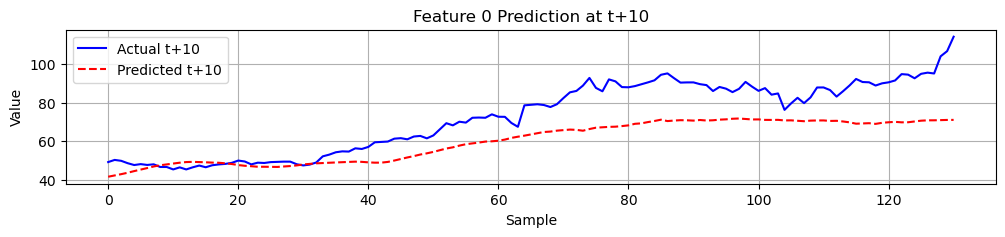


Epoch [40/300] - Training Loss: 0.0004, Validation Loss: 0.0243, Learning Rate: 0.000500
Validation RMSE: 16.202724


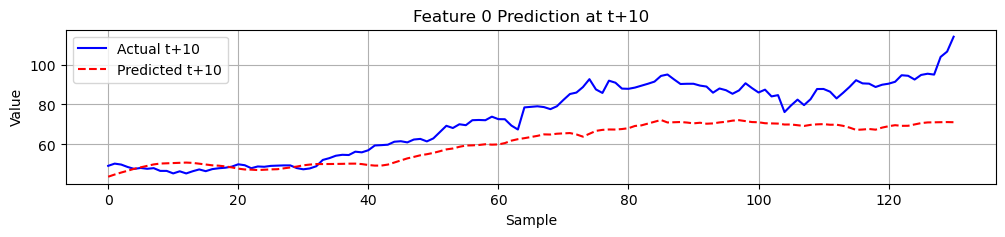


Epoch [60/300] - Training Loss: 0.0004, Validation Loss: 0.0270, Learning Rate: 0.000500
Validation RMSE: 17.152454


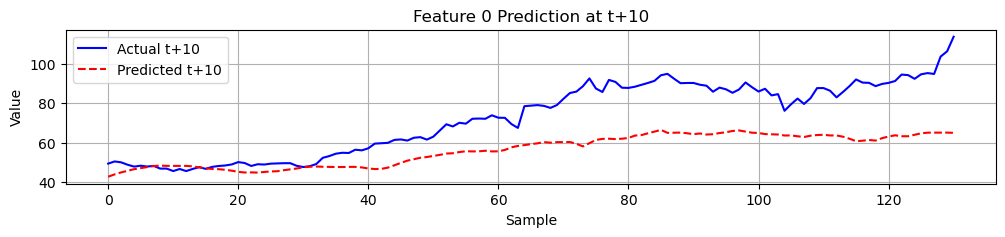


Epoch [80/300] - Training Loss: 0.0003, Validation Loss: 0.0313, Learning Rate: 0.000500
Validation RMSE: 18.456924


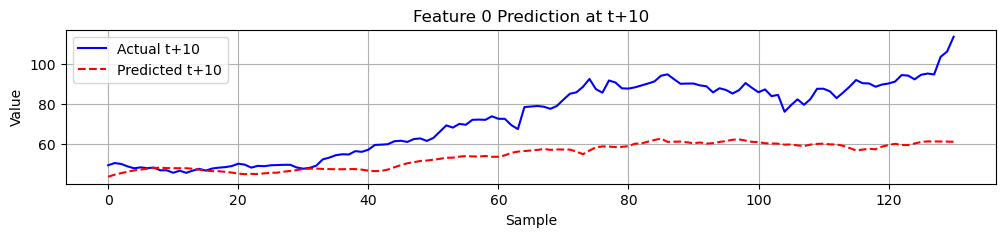


Early stopping! in epoch 82
Training Loss: 0.0003, Validation Loss: 0.0262, Learning Rate: 0.000500
Validation RMSE: 16.683552     std: 2.9859262


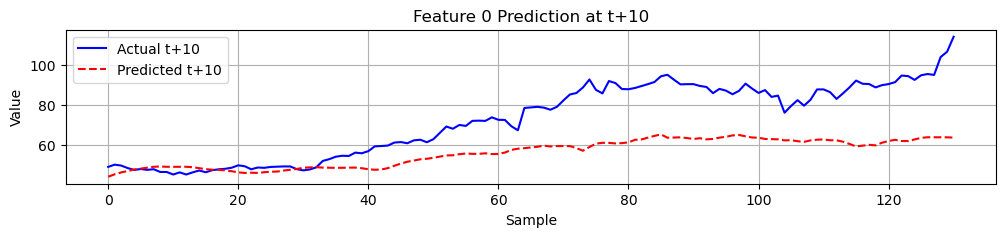

In [34]:
learning_rate = 5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn =  nn.MSELoss()
# loss_fn = nn.L1Loss()
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
 
n_epochs = 300
early_stop_count = 0
min_val_loss = float('inf')
train_hist = []
val_hist = [] 
test_loss = None  

for epoch in range(n_epochs):

    total_loss = 0.0
    
    ''' Training Phase'''
    model.train() 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() 
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    ''' Validation Phase'''
    model.eval()
    total_val_loss = 0.0 
    y_predicted = []
    y_observed = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            y_predicted.append(y_pred.cpu().numpy())
            y_observed.append(y_batch.cpu().numpy())

            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)
    # scheduler.step(average_val_loss)

    predicted = np.concatenate(y_predicted, axis=0)  # Shape: (total_samples, n_steps_out, output_size)
    observed = np.concatenate(y_observed, axis=0)    # Shape: (total_samples, n_steps_out, output_size)

    # Reshape to 2D array for inverse transform
    predicted_flat = predicted.reshape(-1, output_size)
    observed_flat = observed.reshape(-1, output_size)

    # Apply inverse transform
    predicted_inv = mm.inverse_transform(predicted_flat)
    observed_inv = mm.inverse_transform(observed_flat)

    # Reshape back to original shape
    predicted_inv = predicted_inv.reshape(predicted.shape)
    observed_inv = observed_inv.reshape(observed.shape)
    
    rmses = []
    for i in range(predicted_inv.shape[1]):
        rmse = np.sqrt(np.mean((predicted_inv[:, i] - observed_inv[:, i])**2))
        rmses.append(rmse)

    rmse_mean = np.mean(rmses)
    rmse_std = np.std(rmses)

    if average_val_loss < min_val_loss:
        min_val_loss = average_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 30:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Early stopping! in epoch {epoch+1}')
        print(f'Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean, "    std:", rmse_std)
        feature_idx = 0  # Index of the feature to plot
        time_step = 9    # t+10
        # Extract the observed and predicted values for the chosen feature and time step
        observed_t10 = observed_inv[:, time_step, feature_idx]
        predicted_t10 = predicted_inv[:, time_step, feature_idx]
        # Plotting only t+10
        plt.figure(figsize=(12, 2))
        plt.plot(observed_t10, label='Actual t+10', color='blue')
        plt.plot(predicted_t10, label='Predicted t+10', linestyle='--', color='red')
        plt.title(f'Feature {feature_idx} Prediction at t+10')
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        break
    
    if (epoch+1) % 20 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean)
        feature_idx = 0  # Index of the feature to plot
        time_step = 9    # t+10
        observed_t10 = observed_inv[:, time_step, feature_idx]
        predicted_t10 = predicted_inv[:, time_step, feature_idx]
        plt.figure(figsize=(12, 2))
        plt.plot(observed_t10, label='Actual t+10', color='blue')
        plt.plot(predicted_t10, label='Predicted t+10', linestyle='--', color='red')
        plt.title(f'Feature {feature_idx} Prediction at t+10')
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        print()

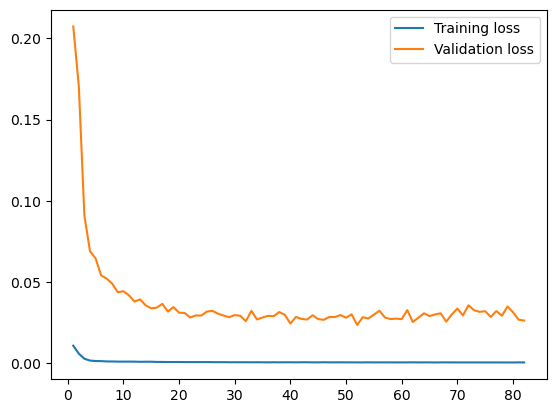

In [35]:
x = np.linspace(1,len(val_hist),len(val_hist))
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.legend()

plt.show()

RMSE promedio at t+10: 31.636547    std: 15.380085


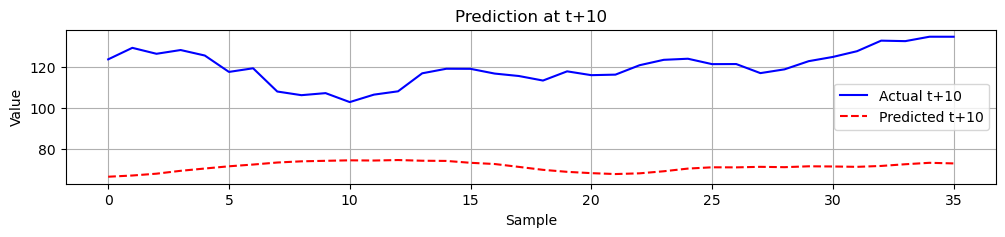

In [36]:
y_predicted = []
y_observed = []

# Final Evaluation on Test Set
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        y_predicted.append(y_pred.cpu().numpy())
        y_observed.append(y_batch.cpu().numpy())

predicted = np.concatenate(y_predicted, axis=0)  # Shape: (total_samples, n_steps_out, output_size)
observed = np.concatenate(y_observed, axis=0)    # Shape: (total_samples, n_steps_out, output_size)

# Reshape to 2D array for inverse transform
predicted_flat = predicted.reshape(-1, output_size)
observed_flat = observed.reshape(-1, output_size)

# Apply inverse transform
predicted_inv = mm.inverse_transform(predicted_flat)
observed_inv = mm.inverse_transform(observed_flat)

# Reshape back to original shape
predicted_inv = predicted_inv.reshape(predicted.shape)
observed_inv = observed_inv.reshape(observed.shape)

# Calculate RMSE for each time series at t+10
for i in range(n_steps_out):
    for j in range(output_size):
        # Extract the true and predicted values for the specific time step and feature
        observed_vals = observed_inv[:, i, j]
        predicted_vals = predicted_inv[:, i, j]
        
        # Compute RMSE for this time step and feature
        mse = np.mean((observed_vals - predicted_vals) ** 2)
        rmse = np.sqrt(mse)
        rmses.append(rmse)

rmse_mean = np.mean(rmses)
rmse_std = np.std(rmses)

print("RMSE promedio at t+10:", rmse_mean, "   std:", rmse_std)

feature_idx = 0  # Index of the feature to plot
time_step = 9    # t+10
# Extract the observed and predicted values for the chosen feature and time step
observed_t10 = observed_inv[:, time_step, feature_idx]
predicted_t10 = predicted_inv[:, time_step, feature_idx]
# Plotting only t+10
plt.figure(figsize=(12, 2))
plt.plot(observed_t10, label='Actual t+10', color='blue')
plt.plot(predicted_t10, label='Predicted t+10', linestyle='--', color='red')
plt.title(f'Prediction at t+10')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
Timeseries_tensor, TTimeseries_tensor = split_sequences(X_trans, y_trans, 50, 10, device)
Timeseries_tensor.shape, TTimeseries_tensor.shape

(torch.Size([891, 50, 3]), torch.Size([891, 10, 1]))

RMSE promedio: 16.523722    std: 1.7032988


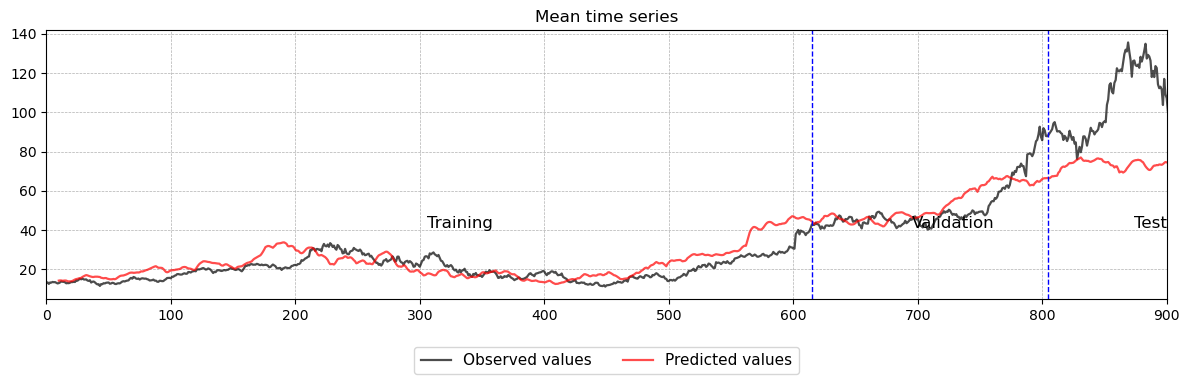

In [78]:
model.eval()
with torch.no_grad():
    y_pred_test = model(Timeseries_tensor)

predicted_2d = y_pred_test.cpu().numpy().reshape(-1, output_size)

observed_2d = TTimeseries_tensor.cpu().numpy().reshape(-1, output_size)

predicted_inv_2d = mm.inverse_transform(predicted_2d)
observed_inv_2d = mm.inverse_transform(observed_2d)

predicted_inv = predicted_inv_2d.reshape(y_pred_test.shape)
observed_inv = observed_inv_2d.reshape(TTimeseries_tensor.shape)

rmses = []
for i in range(predicted_inv.shape[1]):
    rmse = np.sqrt(np.mean((predicted_inv[:, i] - observed_inv[:, i])**2))
    rmses.append(rmse)

best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print("RMSE promedio:", np.mean(rmses), "   std:", np.std(rmses))

plt.figure(figsize=(12, 4))
plt.plot(mm.inverse_transform(y_trans), color='k', linewidth=1.6, alpha=.7, label='Observed values')
plt.plot(range(10, len(predicted_inv) + 10), np.mean(predicted_inv, axis=1), label='Predicted values', linestyle='-', color="red", linewidth=1.6, alpha=0.7)

plt.axvline(x=len(XTrain) - lookback, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain) + len(XValidation) - lookback, color='blue', linestyle='--', linewidth=1)

plt.text(len(XTrain) / 2, np.mean(observed_inv) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed_inv) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed_inv) - 0.3, 'Test', fontsize=12, color='black', ha='center')

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title(f'Mean time series')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


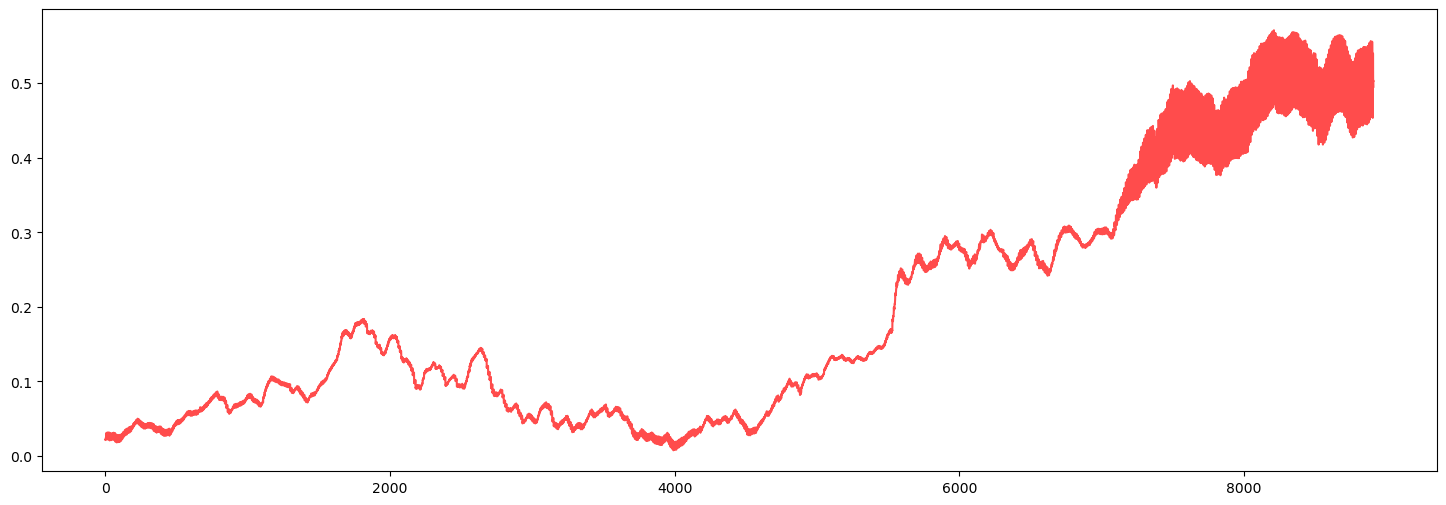

In [91]:
plt.figure(figsize=(18, 6))
plt.plot(predicted_inv_2d, label='Predicted values', linestyle='-', color="red", alpha=0.7)
plt.show()

In [90]:
y_pred_test.cpu().numpy().reshape(-1, output_size)

array([[0.02181765],
       [0.02132048],
       [0.02159464],
       ...,
       [0.5018619 ],
       [0.50380635],
       [0.49531293]], dtype=float32)

In [53]:
predicted_inv.shape

(891, 10, 1)

In [66]:
predicted_inv_2d.shape

array([[13.94009 ],
       [13.878266],
       [13.912357],
       ...,
       [73.63503 ],
       [73.87684 ],
       [72.820656]], dtype=float32)